In [2]:
import os
import sys
sys.path.insert(1, '../')
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import numpy as np
from data_preparation import *
from utils import *
from keras.layers import Bidirectional
from keras.layers.core import Dense, Flatten
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.convolutional import Conv1D
from attention import AttentionLayer
from attention_with_context import AttentionWithContext
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [5]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
print('loading data...')
data1 = load_csv(r'basel_data', 6, "basel_data")
data2 = load_csv(r'basel_data', 2, "basel_data")
data3 = load_csv(r'basel_data', 3, "basel_data")
data4 = load_csv(r'basel_data', 4, "basel_data")
data5 = load_csv(r'basel_data', 5, "basel_data")
data6 = load_csv(r'basel_data', 1, "basel_data")

# data1 = load_csv(r'data-urban/401190', 5, "urban")
# data2 = load_csv(r'data-urban/401144', 7, "urban")
# data3 = load_csv(r'data-urban/401413', 11, "urban")
# data4 = load_csv(r'data-urban/401911', 8, "urban")
# data5 = load_csv(r'data-urban/401610', 10, "urban")
# data6 = load_csv(r'data-urban/401273', 8, "urban")
# data7 = load_csv(r'data-urban/401137', 8, "urban")

epoch = 50
day = 288
week = 2016
seq_len = 15
#1=5min, 3=15min, 6=30min, 12=60min
pre_len = 12
#data 1-7
pre_sens_num = 1


loading data...


In [6]:
data1

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
#train,test
train_data, train_w, train_d, label, test_data, test_w, test_d, test_l, test_med, test_min\
	= generate_data(data1, data2, data3, data4, data5, data6, seq_len, pre_len, pre_sens_num)

train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1))
train_w = np.reshape(train_w,(train_w.shape[0], train_w.shape[1], 1))
train_d = np.reshape(train_d,(train_d.shape[0], train_d.shape[1], 1))

test_data = np.reshape(test_data,(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1))
test_d = np.reshape(test_d,(test_d.shape[0], test_d.shape[1], 1))
test_w = np.reshape(test_w,(test_w.shape[0], test_w.shape[1], 1))

(96363, 15, 6, 1)
(96363, 15, 1)
(96363, 15, 1)


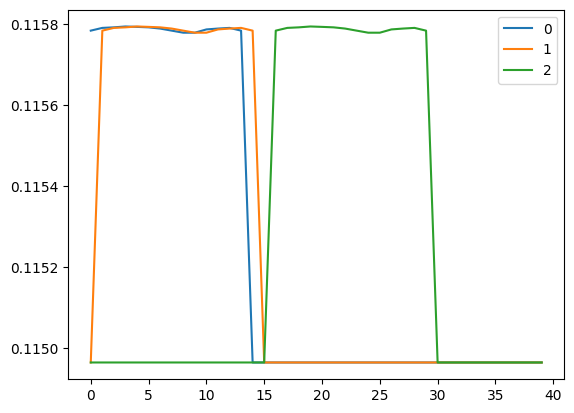

In [35]:
from matplotlib import pyplot as plt
print(train_data.shape)
print(train_w.shape)
print(train_d.shape)
plt.plot(train_data[0:40,0,0])
plt.plot(train_w[0:40,0,0])
plt.plot(train_d[0:40,0,0])
plt.legend(["0", "1", "2"])
plt.show()

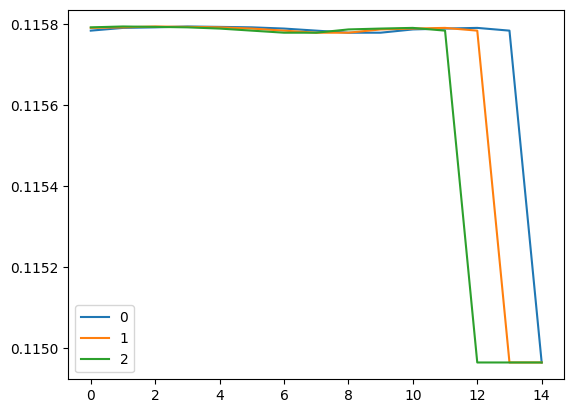

In [47]:
plt.plot(train_data[0,:,0])
plt.plot(train_data[1,:,0])
plt.plot(train_data[2,:,0])
plt.legend(["0", "1", "2"])
plt.show()

In [4]:
# conv-lstm
main_input = Input((15, 7, 1),name='main_input')
con1 = TimeDistributed(Conv1D(filters=15, kernel_size=3, padding='same', activation='relu', strides=1))(main_input)
con2 = TimeDistributed(Conv1D(filters=15, kernel_size=3, padding='same', activation='relu', strides=1))(con1)
#con3 = TimeDistributed(AveragePooling1D(pool_size=2))(con2)
con_fl = TimeDistributed(Flatten())(con2)
con_out = Dense(15)(con_fl)

lstm_out1 = LSTM(15, return_sequences=True)(con_out)
lstm_attention = AttentionWithContext()(lstm_out1)
lstm_out2 = LSTM(15, return_sequences=False)(lstm_attention)
lstm_out3 = AttentionLayer()([lstm_out2, con_out])

# Bilstm
auxiliary_input_w = Input((15, 1), name='auxiliary_input_w')
lstm_outw1 = Bidirectional(LSTM(15, return_sequences=True))(auxiliary_input_w)
lstm_outw2 = Bidirectional(LSTM(15, return_sequences=False))(lstm_outw1)

auxiliary_input_d = Input((15, 1), name='auxiliary_input_d')
lstm_outd1 = Bidirectional(LSTM(15, return_sequences=True))(auxiliary_input_d)
lstm_outd2 = Bidirectional(LSTM(15, return_sequences=False))(lstm_outd1)

x = keras.layers.concatenate([lstm_out3, lstm_outw2, lstm_outd2])
x = Dense(20, activation='relu')(x)
x = Dense(10, activation='relu')(x)
main_output = Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.1, 0.1), name='main_output')(x)
model = Model(inputs = [main_input, auxiliary_input_w, auxiliary_input_d], outputs = main_output)
model.summary()
model.compile(optimizer='adam', loss=my_loss)

NAME:  attention_with_context_1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 15, 7, 1)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 7, 15)    60          main_input[0][0]                 
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 15, 7, 15)    690         time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 15, 105)      0           time_distributed_2[0][0]         
____________________________________________________________

In [22]:
#train_save model
filepath = "model/model_{epoch:04d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min',period=5)
callbacks_list = [checkpoint]

print('Train...')
training_metrics = model.fit([train_data, train_w, train_d], label,
		  batch_size=128, epochs=epoch, validation_split=0.15, verbose=2,
		  class_weight='auto', callbacks=callbacks_list)
model_json = model.to_json()
with open("model/conv_lstm.json", "w") as json_file:
    json_file.write(model_json)
print("Save model to disk")

#load model
# with CustomObjectScope({'AttentionLayer': AttentionLayer}):
# 	json_file = open('model/conv_lstm.json', 'r')
# 	loaded_model_json = json_file.read()
# 	json_file.close()
# 	cnn_lstm_model = model_from_json(loaded_model_json)
# 	cnn_lstm_model.load_weights("model/model_0200-0.0337.h5", 'r')

Train...
Train on 37676 samples, validate on 6649 samples
Epoch 1/50
 - 12s - loss: 0.0038 - val_loss: 0.0036
Epoch 2/50
 - 13s - loss: 0.0037 - val_loss: 0.0034
Epoch 3/50
 - 13s - loss: 0.0036 - val_loss: 0.0033
Epoch 4/50
 - 16s - loss: 0.0036 - val_loss: 0.0037
Epoch 5/50
 - 12s - loss: 0.0038 - val_loss: 0.0032

Epoch 00005: val_loss improved from inf to 0.00325, saving model to model/model_0005-0.0032.h5
Epoch 6/50
 - 11s - loss: 0.0036 - val_loss: 0.0036
Epoch 7/50
 - 15s - loss: 0.0037 - val_loss: 0.0033
Epoch 8/50
 - 11s - loss: 0.0036 - val_loss: 0.0037
Epoch 9/50
 - 11s - loss: 0.0036 - val_loss: 0.0033
Epoch 10/50
 - 11s - loss: 0.0036 - val_loss: 0.0035

Epoch 00010: val_loss did not improve from 0.00325
Epoch 11/50
 - 11s - loss: 0.0037 - val_loss: 0.0037
Epoch 12/50
 - 14s - loss: 0.0036 - val_loss: 0.0033
Epoch 13/50
 - 14s - loss: 0.0037 - val_loss: 0.0034
Epoch 14/50
 - 11s - loss: 0.0036 - val_loss: 0.0033
Epoch 15/50
 - 11s - loss: 0.0035 - val_loss: 0.0037

Epoch 0

In [6]:
#Predict the last model
predicted = predict_point_by_point(model, [test_data, test_w, test_d])
p_real = []
l_real = []
row=2016
for i in range(row):
    p_real.append(predicted[i] * test_med + test_min)
    l_real.append(test_l[i] * test_med + test_min)
p_real = np.array(p_real)
l_real = np.array(l_real)

print ("MAE:", MAE(p_real, l_real))
print ("MAPE:", MAPE(p_real, l_real))
print ("RMSE:", RMSE(p_real, l_real))

predict_size: 2016
MAE: 12.950496581124348
MAPE: 0.18810175983507732
RMSE: 17.920760862040613
